In [6]:
# ============================================
# EMOTION CLASSIFICATION WITH MLP
# ============================================
# Competition: CSI ML Sprint 2026
# Task: Multi-class emotion classification (6 classes)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Emotion mapping
emotions = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
emotions_reverse = {v: k for k, v in emotions.items()}

print("=" * 50)
print("DATASET OVERVIEW")
print("=" * 50)
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nTrain columns: {train_df.columns.tolist()}")
print(f"Test columns: {test_df.columns.tolist()}")
print(f"\nMissing values in train:\n{train_df.isnull().sum()}")
print(f"\nMissing values in test:\n{test_df.isnull().sum()}")
print(f"\nSample data:")
train_df.head(100)


DATASET OVERVIEW
Training samples: 9961
Test samples: 2000

Train columns: ['id', 'text', 'label']
Test columns: ['id', 'text ']

Missing values in train:
id       0
text     0
label    0
dtype: int64

Missing values in test:
id       0
text     0
dtype: int64

Sample data:


,id,text,label
0,1,i didnt feel humiliated 😔,0
1,2,i can go from feeling so hopeless 😞 to so damn...,0
2,3,im grabbing a minute to post i feel greedy 🤑 w...,3
3,4,i am ever feeling nostalgic 🕰️ about the firep...,2
4,5,i am feeling grouchy 😠,3
...,...,...,...
95,96,i feel like its perfect ✨ i even know trends 📈,1
96,97,i specifically wanted tango 💃 was feeling shy ...,4
97,98,i also didn t feel very weird 🤨 sleeping in my...,4
98,99,being all cooped up 🏠 and restless 😩 has made ...,0


## 1. Exploratory Data Analysis (EDA)

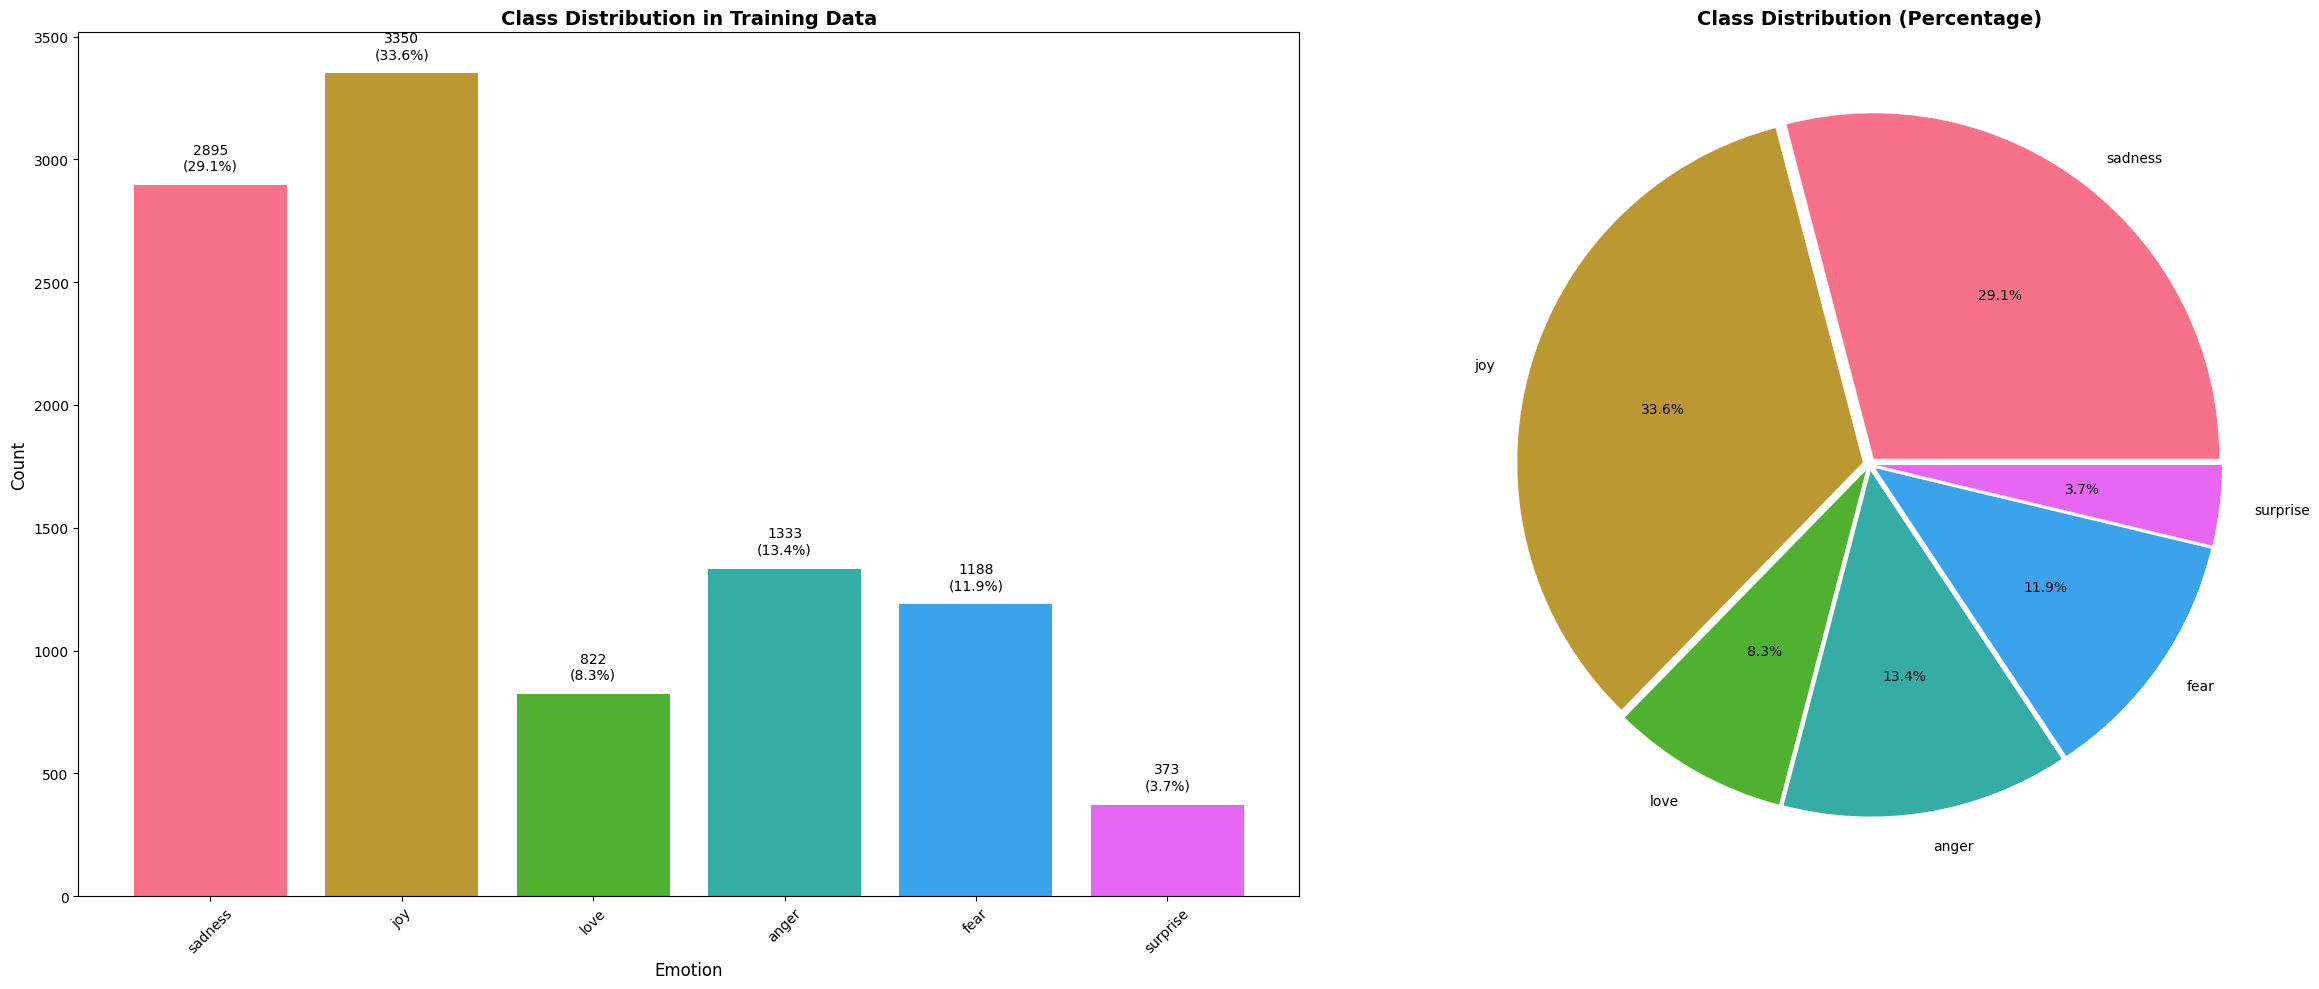


CLASS IMBALANCE ANALYSIS
Class counts:
label
0    2895
1    3350
2     822
3    1333
4    1188
5     373
Name: count, dtype: int64

Imbalance ratio (max/min): 8.98
Most common: joy (3350 samples)
Least common: surprise (373 samples)


In [11]:
# ============================================
# 1.1 CLASS DISTRIBUTION ANALYSIS
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(25, 10))

# Count plot
class_counts = train_df['label'].value_counts().sort_index()
colors = sns.color_palette("husl", 6)

ax1 = axes[0]
bars = ax1.bar([emotions[i] for i in class_counts.index], class_counts.values, color=colors)
ax1.set_xlabel('Emotion', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Class Distribution in Training Data', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, count in zip(bars, class_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{count}\n({count/len(train_df)*100:.1f}%)',
             ha='center', va='bottom', fontsize=10)

# Pie chart
ax2 = axes[1]
ax2.pie(class_counts.values, labels=[emotions[i] for i in class_counts.index],
        autopct='%1.1f%%', colors=colors, explode=[0.02]*6)
ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check for class imbalance
print("\n" + "=" * 50)
print("CLASS IMBALANCE ANALYSIS")
print("=" * 50)
print(f"Class counts:\n{class_counts}")
print(f"\nImbalance ratio (max/min): {class_counts.max()/class_counts.min():.2f}")
print(f"Most common: {emotions[class_counts.idxmax()]} ({class_counts.max()} samples)")
print(f"Least common: {emotions[class_counts.idxmin()]} ({class_counts.min()} samples)")


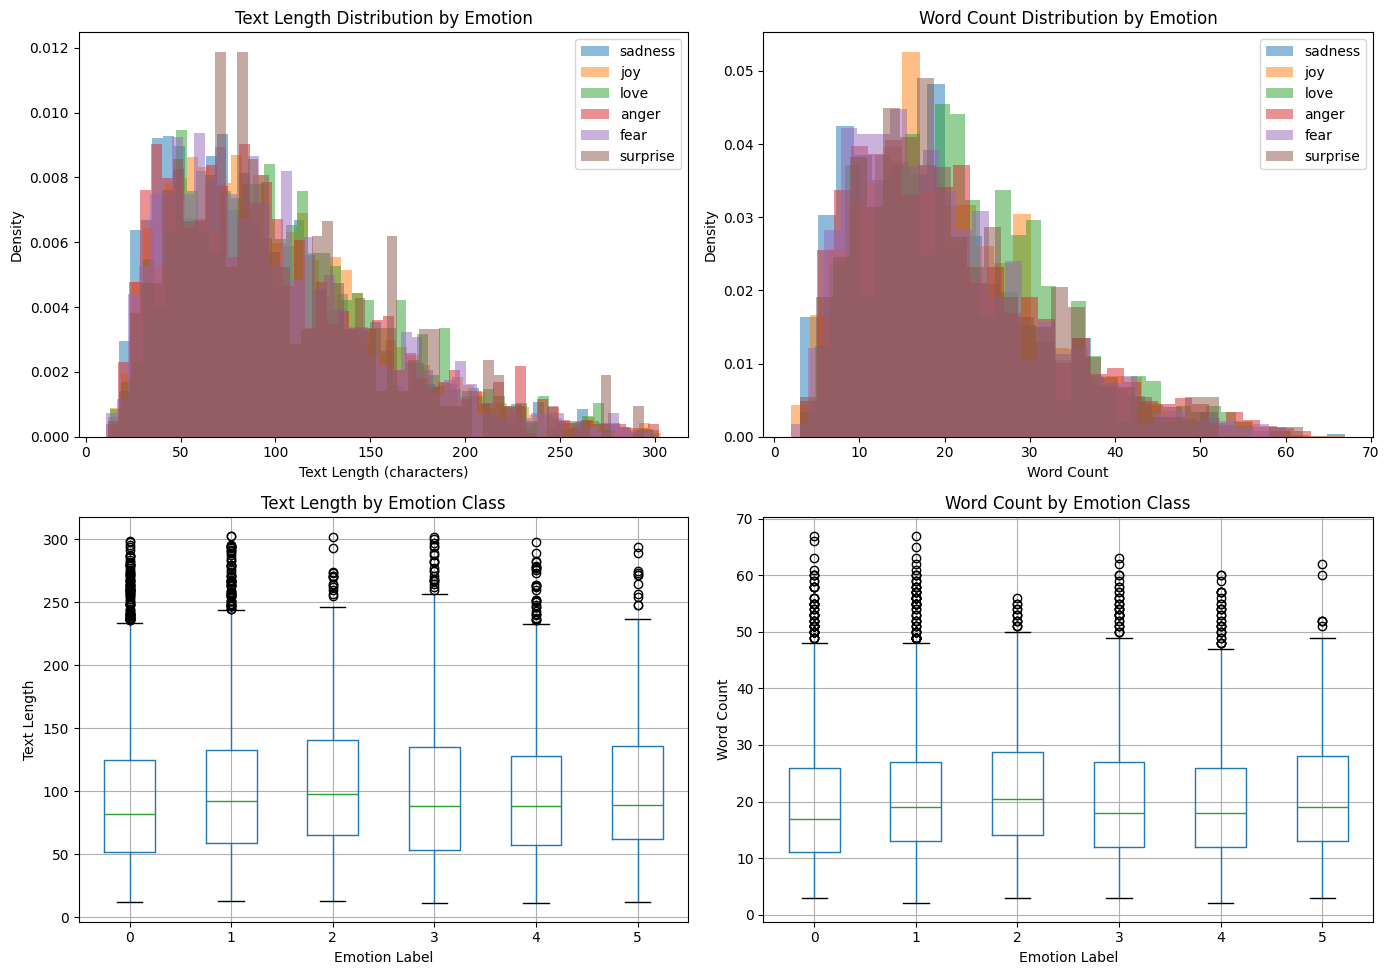


TEXT LENGTH STATISTICS BY EMOTION
      text_length                 word_count               
             mean    std min  max       mean    std min max
label                                                      
0           95.66  56.07  12  299      19.67  11.13   3  67
1          101.68  54.95  13  303      20.82  10.83   2  67
2          107.21  54.54  13  302      22.07  10.70   3  56
3          100.43  58.80  11  302      20.68  11.78   3  63
4           98.54  54.51  11  298      20.02  10.88   2  60
5          104.01  56.97  12  294      21.08  11.17   3  62


In [ ]:
# ============================================
# 1.2 TEXT LENGTH ANALYSIS
# ============================================

# Clean column names in test_df to remove any trailing spaces
test_df.columns = test_df.columns.str.strip()

# Add text length features
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['text_length'] = test_df['text'].apply(len)
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Text length distribution by emotion
ax1 = axes[0, 0]
for label in sorted(train_df['label'].unique()):
    subset = train_df[train_df['label'] == label]['text_length']
    ax1.hist(subset, bins=50, alpha=0.5, label=emotions[label], density=True)
ax1.set_xlabel('Text Length (characters)')
ax1.set_ylabel('Density')
ax1.set_title('Text Length Distribution by Emotion')
ax1.legend()

# Word count distribution by emotion
ax2 = axes[0, 1]
for label in sorted(train_df['label'].unique()):
    subset = train_df[train_df['label'] == label]['word_count']
    ax2.hist(subset, bins=30, alpha=0.5, label=emotions[label], density=True)
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Density')
ax2.set_title('Word Count Distribution by Emotion')
ax2.legend()

# Box plot for text length
ax3 = axes[1, 0]
train_df.boxplot(column='text_length', by='label', ax=ax3)
ax3.set_xlabel('Emotion Label')
ax3.set_ylabel('Text Length')
ax3.set_title('Text Length by Emotion Class')
plt.suptitle('')

# Box plot for word count
ax4 = axes[1, 1]
train_df.boxplot(column='word_count', by='label', ax=ax4)
ax4.set_xlabel('Emotion Label')
ax4.set_ylabel('Word Count')
ax4.set_title('Word Count by Emotion Class')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Statistics
print("\n" + "=" * 50)
print("TEXT LENGTH STATISTICS BY EMOTION")
print("=" * 50)
print(train_df.groupby('label').agg({
    'text_length': ['mean', 'std', 'min', 'max'],
    'word_count': ['mean', 'std', 'min', 'max']
}).round(2))


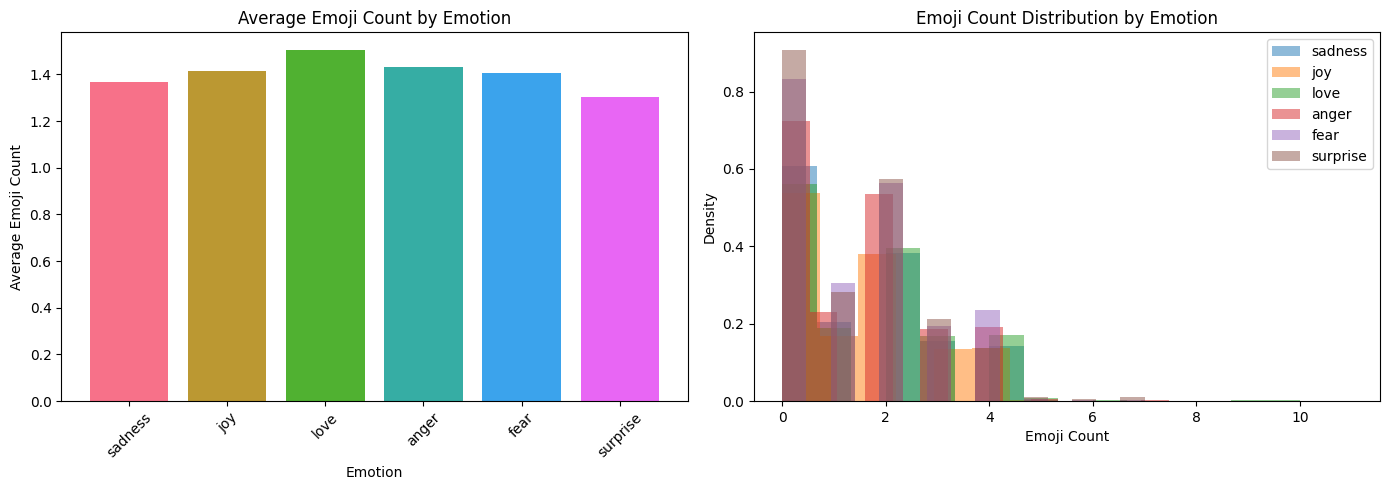


EMOJI STATISTICS
Samples with emojis: 6027 (60.5%)
Average emojis per sample: 1.41

Emoji count by emotion:
       mean   std  max
label                 
0      1.37  1.39   10
1      1.41  1.41   11
2      1.50  1.47   10
3      1.43  1.40    8
4      1.41  1.39    7
5      1.30  1.39    7


In [18]:
# ============================================
# 1.3 EMOJI ANALYSIS (Important for this dataset!)
# ============================================
import re
import emoji

def extract_emojis(text):
    """Extract all emojis from text"""
    return ''.join(c for c in text if c in emoji.EMOJI_DATA)

def count_emojis(text):
    """Count emojis in text"""
    return len([c for c in text if c in emoji.EMOJI_DATA])

train_df['emoji_count'] = train_df['text'].apply(count_emojis)
train_df['emojis'] = train_df['text'].apply(extract_emojis)
test_df['emoji_count'] = test_df['text'].apply(count_emojis)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Emoji count distribution by emotion
ax1 = axes[0]
emoji_by_emotion = train_df.groupby('label')['emoji_count'].mean()
bars = ax1.bar([emotions[i] for i in emoji_by_emotion.index], emoji_by_emotion.values, color=colors)
ax1.set_xlabel('Emotion')
ax1.set_ylabel('Average Emoji Count')
ax1.set_title('Average Emoji Count by Emotion')
ax1.tick_params(axis='x', rotation=45)

# Emoji count distribution
ax2 = axes[1]
for label in sorted(train_df['label'].unique()):
    subset = train_df[train_df['label'] == label]['emoji_count']
    ax2.hist(subset, bins=15, alpha=0.5, label=emotions[label], density=True)
ax2.set_xlabel('Emoji Count')
ax2.set_ylabel('Density')
ax2.set_title('Emoji Count Distribution by Emotion')
ax2.legend()

plt.tight_layout()
plt.show()

print("\n" + "=" * 50)
print("EMOJI STATISTICS")
print("=" * 50)
print(f"Samples with emojis: {(train_df['emoji_count'] > 0).sum()} ({(train_df['emoji_count'] > 0).mean()*100:.1f}%)")
print(f"Average emojis per sample: {train_df['emoji_count'].mean():.2f}")
print(f"\nEmoji count by emotion:")
print(train_df.groupby('label')['emoji_count'].agg(['mean', 'std', 'max']).round(2))


## 2. Text Preprocessing & Feature Engineering

In [ ]:
# ============================================
# 2.1 ADVANCED TEXT PREPROCESSING
# ============================================
import re
import string
from sklearn.preprocessing import LabelEncoder, StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
try:
    nltk.data.find('corpora/stopwords')
except:
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('punkt', quiet=True)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Keep emotion-related stopwords (important for sentiment!)
emotion_stopwords_to_keep = {'not', 'no', 'never', 'very', 'too', 'so', 'just', 'more', 'most', 'only'}
stop_words = stop_words - emotion_stopwords_to_keep

# ============================================
# EMOJI TO EMOTION MAPPING (Weighted by emotion)
# ============================================
EMOJI_EMOTION_MAP = {
    # SADNESS (label=0) - weight: high
    '😔': ('sadness', 2.0), '😢': ('sadness', 2.0), '😭': ('sadness', 2.5), '😞': ('sadness', 2.0),
    '😿': ('sadness', 2.0), '💔': ('sadness', 2.5), '😥': ('sadness', 1.8), '😰': ('sadness', 1.5),
    '🥺': ('sadness', 1.8), '😩': ('sadness', 1.8), '😫': ('sadness', 1.5), '💧': ('sadness', 1.2),
    '🌧️': ('sadness', 1.0), '☔': ('sadness', 1.0), '🕳️': ('sadness', 1.5),
    
    # JOY (label=1) - weight: high
    '😊': ('joy', 2.0), '😄': ('joy', 2.0), '😃': ('joy', 2.0), '🥳': ('joy', 2.5),
    '🎉': ('joy', 2.0), '🎊': ('joy', 2.0), '✨': ('joy', 1.5), '🌟': ('joy', 1.5),
    '😁': ('joy', 2.0), '😆': ('joy', 1.8), '🙂': ('joy', 1.2), '☺️': ('joy', 1.5),
    '🌈': ('joy', 1.8), '🎈': ('joy', 1.5), '🍀': ('joy', 1.2), '🌻': ('joy', 1.5),
    '🌞': ('joy', 1.5), '💫': ('joy', 1.3),
    
    # LOVE (label=2) - weight: high
    '❤️': ('love', 2.5), '💕': ('love', 2.5), '💓': ('love', 2.0), '💗': ('love', 2.0),
    '💖': ('love', 2.0), '💘': ('love', 2.0), '💝': ('love', 2.0), '😍': ('love', 2.5),
    '🥰': ('love', 2.5), '😘': ('love', 2.0), '💑': ('love', 2.0), '💏': ('love', 2.0),
    '🌹': ('love', 1.8), '💐': ('love', 1.5), '🧸': ('love', 1.2), '🤗': ('love', 1.5),
    
    # ANGER (label=3) - weight: high
    '😠': ('anger', 2.5), '😡': ('anger', 2.5), '🤬': ('anger', 3.0), '💢': ('anger', 2.5),
    '👿': ('anger', 2.0), '😤': ('anger', 2.0), '💥': ('anger', 1.8), '🔥': ('anger', 1.5),
    '⚔️': ('anger', 1.5), '💣': ('anger', 1.8), '😾': ('anger', 1.8),
    
    # FEAR (label=4) - weight: high
    '😨': ('fear', 2.5), '😱': ('fear', 2.5), '😰': ('fear', 2.0), '😟': ('fear', 2.0),
    '😧': ('fear', 1.8), '🙀': ('fear', 2.0), '⚠️': ('fear', 1.5), '🔦': ('fear', 1.2),
    '👻': ('fear', 1.5), '💀': ('fear', 1.5), '☠️': ('fear', 1.5), '😖': ('fear', 1.8),
    
    # SURPRISE (label=5) - weight: high
    '😮': ('surprise', 2.0), '😲': ('surprise', 2.5), '🤯': ('surprise', 2.5), '😯': ('surprise', 2.0),
    '🙊': ('surprise', 1.8), '❗': ('surprise', 1.5), '❓': ('surprise', 1.2), '🤔': ('surprise', 1.2),
    '😳': ('surprise', 2.0), '👀': ('surprise', 1.5),
}

EMOTION_TO_LABEL = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

def advanced_preprocess_text(text):
    """Advanced text preprocessing with better filtering"""
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    
    # Keep hashtag text
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Remove numbers (they're usually not emotionally relevant)
    text = re.sub(r'\d+', '', text)
    
    # Normalize repeated characters (e.g., "soooo" -> "soo")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def lemmatize_text(text):
    """Lemmatize text while keeping important words"""
    words = text.split()
    lemmatized = []
    for word in words:
        # Skip stopwords but keep negations
        if word in stop_words:
            continue
        # Lemmatize
        lemmatized.append(lemmatizer.lemmatize(word))
    return ' '.join(lemmatized)

def extract_emoji_features(text):
    """Extract weighted emoji features for each emotion"""
    features = {f'emoji_{emotion}_score': 0.0 for emotion in EMOTION_TO_LABEL.keys()}
    
    for char in text:
        if char in EMOJI_EMOTION_MAP:
            emotion, weight = EMOJI_EMOTION_MAP[char]
            features[f'emoji_{emotion}_score'] += weight
    
    return features

def remove_emojis(text):
    """Remove emojis from text but keep track of them separately"""
    # Emoji pattern covering most common emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"
        "]+", 
        flags=re.UNICODE
    )
    return emoji_pattern.sub('', text).strip()

# Apply advanced preprocessing
train_df['text_clean'] = train_df['text'].apply(advanced_preprocess_text)
train_df['text_no_emoji'] = train_df['text_clean'].apply(remove_emojis)
train_df['text_lemmatized'] = train_df['text_no_emoji'].apply(lemmatize_text)

test_df['text_clean'] = test_df['text'].apply(advanced_preprocess_text)
test_df['text_no_emoji'] = test_df['text_clean'].apply(remove_emojis)
test_df['text_lemmatized'] = test_df['text_no_emoji'].apply(lemmatize_text)

print("Sample preprocessed texts:")
for i in range(3):
    print(f"\nOriginal:   {train_df['text'].iloc[i][:80]}...")
    print(f"Cleaned:    {train_df['text_clean'].iloc[i][:80]}...")
    print(f"Lemmatized: {train_df['text_lemmatized'].iloc[i][:80]}...")


Sample preprocessed texts:

Original: i didnt feel humiliated 😔
Cleaned:  i didnt feel humiliated 😔
No emoji: i didnt feel humiliated 

Original: i can go from feeling so hopeless 😞 to so damned hopeful 🌈 just from being around someone who cares ❤️ and is awake 🌅
Cleaned:  i can go from feeling so hopeless 😞 to so damned hopeful 🌈 just from being around someone who cares ❤️ and is awake 🌅
No emoji: i can go from feeling so hopeless  to so damned hopeful  just from being around someone who cares ️ and is awake 

Original: im grabbing a minute to post i feel greedy 🤑 wrong ❌
Cleaned:  im grabbing a minute to post i feel greedy 🤑 wrong ❌
No emoji: im grabbing a minute to post i feel greedy  wrong 


In [ ]:
# ============================================
# 2.2 TEXT FEATURES FROM SCRATCH (No TF-IDF, No Pretrained)
# ============================================
# Build all features manually using basic techniques

import numpy as np
import re
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

print("=" * 60)
print("BUILDING TEXT FEATURES FROM SCRATCH")
print("=" * 60)

# ==================== 1. BUILD VOCABULARY ====================
print("\n1. Building vocabulary from training data...")

def tokenize(text):
    """Simple word tokenizer"""
    # Lowercase and split on whitespace/punctuation
    text = str(text).lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

# Count all words in training data
all_tokens = []
for text in train_df['text_lemmatized']:
    all_tokens.extend(tokenize(text))

word_counts = Counter(all_tokens)
print(f"   Total unique words: {len(word_counts)}")

# Keep words appearing at least 2 times
MIN_FREQ = 2
vocab_list = [word for word, count in word_counts.most_common() if count >= MIN_FREQ]
vocab = {word: idx for idx, word in enumerate(vocab_list)}
VOCAB_SIZE = len(vocab)
print(f"   Vocabulary size (freq >= {MIN_FREQ}): {VOCAB_SIZE}")

# ==================== 2. BAG OF WORDS (Manual Implementation) ====================
print("\n2. Creating Bag-of-Words features...")

def text_to_bow(text, vocab):
    """Convert text to bag-of-words vector"""
    tokens = tokenize(text)
    bow = np.zeros(len(vocab))
    for token in tokens:
        if token in vocab:
            bow[vocab[token]] += 1
    # Normalize by document length
    if bow.sum() > 0:
        bow = bow / bow.sum()
    return bow

# Create BoW matrices (use subset of vocab for efficiency)
MAX_FEATURES = min(5000, VOCAB_SIZE)
top_vocab = {word: idx for idx, word in enumerate(vocab_list[:MAX_FEATURES])}

X_bow_train = np.array([text_to_bow(text, top_vocab) for text in train_df['text_lemmatized']])
X_bow_test = np.array([text_to_bow(text, top_vocab) for text in test_df['text_lemmatized']])
print(f"   BoW shape: {X_bow_train.shape}")

# ==================== 3. SVD FOR DIMENSIONALITY REDUCTION ====================
print("\n3. Applying SVD for dimensionality reduction...")

N_COMPONENTS = 200
bow_sparse = csr_matrix(X_bow_train)
U, S, Vt = svds(bow_sparse, k=min(N_COMPONENTS, MAX_FEATURES - 1))

# Project training data
X_svd_train = U * S
# Project test data
X_svd_test = csr_matrix(X_bow_test) @ Vt.T

print(f"   SVD shape: {X_svd_train.shape}")

# ==================== 4. N-GRAM FEATURES (Character level) ====================
print("\n4. Creating character n-gram features...")

def get_char_ngrams(text, n=3):
    """Extract character n-grams"""
    text = str(text).lower()
    ngrams = []
    for i in range(len(text) - n + 1):
        ngrams.append(text[i:i+n])
    return ngrams

# Build character n-gram vocabulary from training data
char_ngram_counts = Counter()
for text in train_df['text_clean']:
    char_ngram_counts.update(get_char_ngrams(text, 3))

# Keep top n-grams
TOP_NGRAMS = 1000
top_ngrams = [ng for ng, _ in char_ngram_counts.most_common(TOP_NGRAMS)]
ngram_vocab = {ng: idx for idx, ng in enumerate(top_ngrams)}

def text_to_ngram_vec(text, ngram_vocab):
    """Convert text to character n-gram vector"""
    ngrams = get_char_ngrams(text, 3)
    vec = np.zeros(len(ngram_vocab))
    for ng in ngrams:
        if ng in ngram_vocab:
            vec[ngram_vocab[ng]] += 1
    if vec.sum() > 0:
        vec = vec / vec.sum()
    return vec

X_ngram_train = np.array([text_to_ngram_vec(text, ngram_vocab) for text in train_df['text_clean']])
X_ngram_test = np.array([text_to_ngram_vec(text, ngram_vocab) for text in test_df['text_clean']])

# SVD on n-grams
N_NGRAM_COMPONENTS = 50
ngram_sparse = csr_matrix(X_ngram_train)
U_ng, S_ng, Vt_ng = svds(ngram_sparse, k=min(N_NGRAM_COMPONENTS, TOP_NGRAMS - 1))
X_ngram_svd_train = U_ng * S_ng
X_ngram_svd_test = csr_matrix(X_ngram_test) @ Vt_ng.T

print(f"   Char n-gram SVD shape: {X_ngram_svd_train.shape}")

# ==================== 5. STATISTICAL TEXT FEATURES ====================
print("\n5. Extracting statistical features...")

def extract_text_statistics(df):
    """Extract comprehensive text statistics"""
    features = pd.DataFrame()
    
    # Length features
    features['char_count'] = df['text'].apply(len)
    features['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    features['avg_word_len'] = df['text'].apply(
        lambda x: np.mean([len(w) for w in str(x).split()]) if str(x).split() else 0
    )
    features['max_word_len'] = df['text'].apply(
        lambda x: max([len(w) for w in str(x).split()]) if str(x).split() else 0
    )
    features['min_word_len'] = df['text'].apply(
        lambda x: min([len(w) for w in str(x).split()]) if str(x).split() else 0
    )
    
    # Vocabulary richness
    features['unique_words'] = df['text'].apply(lambda x: len(set(str(x).lower().split())))
    features['unique_ratio'] = features['unique_words'] / features['word_count'].clip(lower=1)
    
    # Punctuation counts
    features['exclamation'] = df['text'].apply(lambda x: str(x).count('!'))
    features['question'] = df['text'].apply(lambda x: str(x).count('?'))
    features['period'] = df['text'].apply(lambda x: str(x).count('.'))
    features['comma'] = df['text'].apply(lambda x: str(x).count(','))
    features['ellipsis'] = df['text'].apply(lambda x: str(x).count('...'))
    
    # Capitalization
    features['uppercase_count'] = df['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    features['uppercase_ratio'] = features['uppercase_count'] / features['char_count'].clip(lower=1)
    features['all_caps_words'] = df['text'].apply(
        lambda x: sum(1 for w in str(x).split() if w.isupper() and len(w) > 1)
    )
    
    # Special patterns
    features['repeated_chars'] = df['text'].apply(lambda x: len(re.findall(r'(.)\1{2,}', str(x))))
    features['digit_count'] = df['text'].apply(lambda x: sum(c.isdigit() for c in str(x)))
    features['space_count'] = df['text'].apply(lambda x: str(x).count(' '))
    
    # Sentence structure
    features['sentence_count'] = df['text'].apply(lambda x: len(re.split(r'[.!?]+', str(x))))
    features['avg_sentence_len'] = features['word_count'] / features['sentence_count'].clip(lower=1)
    
    return features

train_stats = extract_text_statistics(train_df)
test_stats = extract_text_statistics(test_df)

# Scale statistical features
stats_scaler = StandardScaler()
X_stats_train = stats_scaler.fit_transform(train_stats)
X_stats_test = stats_scaler.transform(test_stats)
print(f"   Statistical features: {X_stats_train.shape}")

# ==================== 6. COMBINE ALL FEATURES ====================
print("\n6. Combining all features...")

X_text_train = np.hstack([
    X_svd_train,           # Word BoW SVD
    X_ngram_svd_train,     # Char n-gram SVD  
    X_stats_train          # Statistical features
]).astype(np.float32)

X_text_test = np.hstack([
    X_svd_test,
    X_ngram_svd_test,
    X_stats_test
]).astype(np.float32)

# Handle any NaN/Inf values
X_text_train = np.nan_to_num(X_text_train, nan=0.0, posinf=0.0, neginf=0.0)
X_text_test = np.nan_to_num(X_text_test, nan=0.0, posinf=0.0, neginf=0.0)

print(f"\n" + "=" * 60)
print(f"FINAL TEXT FEATURES (All From Scratch)")
print(f"=" * 60)
print(f"   Word BoW SVD:     {X_svd_train.shape[1]} dims")
print(f"   Char n-gram SVD:  {X_ngram_svd_train.shape[1]} dims")
print(f"   Statistical:      {X_stats_train.shape[1]} dims")
print(f"   ─────────────────────────────")
print(f"   Total:            {X_text_train.shape[1]} dims")
print(f"\nTrain shape: {X_text_train.shape}")
print(f"Test shape:  {X_text_test.shape}")


TF-IDF features shape: Train (9961, 5000), Test (2000, 5000)
Vocabulary size: 5000

Sample features: ['abilities', 'ability', 'ability to', 'able', 'able to', 'about', 'about all', 'about and', 'about anything', 'about as', 'about being', 'about everything', 'about getting', 'about going', 'about having', 'about his', 'about how', 'about it', 'about life', 'about me']


In [ ]:
# ============================================
# 2.3 ADVANCED HANDCRAFTED FEATURES + WEIGHTED EMOJI
# ============================================

# Emotion lexicons (expanded)
EMOTION_LEXICONS = {
    'sadness': ['sad', 'unhappy', 'depressed', 'miserable', 'heartbroken', 'lonely', 'hopeless', 
                'grief', 'sorrow', 'melancholy', 'gloomy', 'despair', 'cry', 'tears', 'hurt',
                'disappointed', 'upset', 'down', 'blue', 'low', 'empty', 'lost', 'miss', 'regret'],
    'joy': ['happy', 'joy', 'excited', 'wonderful', 'amazing', 'great', 'fantastic', 'excellent',
            'delighted', 'thrilled', 'elated', 'cheerful', 'glad', 'pleased', 'grateful', 'blessed',
            'lucky', 'awesome', 'brilliant', 'love', 'enjoy', 'fun', 'laugh', 'smile', 'celebrate'],
    'love': ['love', 'adore', 'cherish', 'romantic', 'passionate', 'affection', 'caring', 'tender',
             'devoted', 'fond', 'attached', 'intimate', 'sweetheart', 'darling', 'beloved', 'heart',
             'soulmate', 'crush', 'attracted', 'admire', 'treasure', 'warm', 'embrace', 'kiss'],
    'anger': ['angry', 'furious', 'mad', 'rage', 'hate', 'annoyed', 'irritated', 'frustrated',
              'outraged', 'hostile', 'bitter', 'resentful', 'disgusted', 'offended', 'upset',
              'pissed', 'livid', 'enraged', 'infuriated', 'agitated', 'provoked', 'fuming'],
    'fear': ['afraid', 'scared', 'terrified', 'anxious', 'worried', 'nervous', 'panic', 'dread',
             'frightened', 'fearful', 'horror', 'alarmed', 'uneasy', 'tense', 'stressed', 'paranoid',
             'threatened', 'insecure', 'overwhelmed', 'helpless', 'vulnerable', 'uncertain'],
    'surprise': ['surprised', 'shocked', 'amazed', 'astonished', 'stunned', 'unexpected', 'wow',
                 'unbelievable', 'incredible', 'startled', 'bewildered', 'speechless', 'confused',
                 'sudden', 'strange', 'weird', 'odd', 'unusual', 'remarkable', 'extraordinary']
}

def extract_advanced_features(df, emoji_weight=2.0):
    """Extract advanced handcrafted features with weighted emoji scores"""
    features = pd.DataFrame()
    
    # Basic text statistics
    features['text_length'] = df['text'].apply(len)
    features['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    features['avg_word_length'] = df['text'].apply(
        lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0
    )
    features['unique_word_ratio'] = df['text'].apply(
        lambda x: len(set(str(x).lower().split())) / max(len(str(x).split()), 1)
    )
    
    # Punctuation features
    features['exclamation_count'] = df['text'].apply(lambda x: x.count('!'))
    features['question_count'] = df['text'].apply(lambda x: x.count('?'))
    features['ellipsis_count'] = df['text'].apply(lambda x: x.count('...'))
    features['punctuation_ratio'] = df['text'].apply(
        lambda x: sum(1 for c in x if c in string.punctuation) / max(len(x), 1)
    )
    
    # Capitalization (emotional intensity)
    features['caps_ratio'] = df['text'].apply(
        lambda x: sum(1 for c in x if c.isupper()) / max(len(x), 1)
    )
    features['caps_words'] = df['text'].apply(
        lambda x: sum(1 for w in x.split() if w.isupper() and len(w) > 1)
    )
    
    # Basic emoji count
    features['emoji_count'] = df['text'].apply(count_emojis)
    features['emoji_ratio'] = features['emoji_count'] / features['text_length'].clip(lower=1)
    
    # WEIGHTED EMOJI SCORES PER EMOTION (key feature!)
    emoji_features = df['text'].apply(extract_emoji_features).apply(pd.Series)
    # Apply weight multiplier
    emoji_features = emoji_features * emoji_weight
    features = pd.concat([features, emoji_features], axis=1)
    
    # Emotion lexicon scores
    for emotion, words in EMOTION_LEXICONS.items():
        features[f'lexicon_{emotion}'] = df['text_clean'].apply(
            lambda x: sum(1 for word in x.split() if word in words)
        )
    
    # Negation count (affects sentiment)
    negations = ['not', 'no', 'never', 'neither', "n't", 'nobody', 'nothing', 'nowhere']
    features['negation_count'] = df['text_clean'].apply(
        lambda x: sum(1 for word in x.split() if word in negations)
    )
    
    # Intensifiers (emotional intensity)
    intensifiers = ['very', 'so', 'really', 'extremely', 'incredibly', 'absolutely', 'totally', 'completely']
    features['intensifier_count'] = df['text_clean'].apply(
        lambda x: sum(1 for word in x.split() if word in intensifiers)
    )
    
    return features

# Extract features with emoji weight
EMOJI_WEIGHT = 2.5  # Increase emoji importance
train_features = extract_advanced_features(train_df, emoji_weight=EMOJI_WEIGHT)
test_features = extract_advanced_features(test_df, emoji_weight=EMOJI_WEIGHT)

# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

print(f"Advanced features shape: {train_features.shape}")
print(f"\nFeature names ({len(train_features.columns)}):")
print(train_features.columns.tolist())
print(f"\nEmoji emotion scores sample:")
print(train_features[[c for c in train_features.columns if 'emoji_' in c]].head())


Handcrafted features shape: (9961, 11)

Feature names: ['text_length', 'word_count', 'avg_word_length', 'emoji_count', 'exclamation_count', 'question_count', 'punctuation_ratio', 'caps_ratio', 'positive_word_count', 'negative_word_count', 'emoji_ratio']

Feature statistics:


,text_length,word_count,avg_word_length,emoji_count,exclamation_count,question_count,punctuation_ratio,caps_ratio,positive_word_count,negative_word_count,emoji_ratio
count,9961.00,9961.00,9961.00,9961.00,9961.0,9961.0,9961.00,9961.0,9961.00,9961.00,9961.00
mean,99.93,20.48,3.90,1.41,0.0,0.0,0.00,0.0,0.10,0.05,0.02
std,55.89,11.08,0.58,1.41,0.0,0.0,0.00,0.0,0.34,0.25,0.02
min,11.00,2.00,2.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00
25%,57.00,12.00,3.52,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00
50%,89.00,18.00,3.86,1.00,0.0,0.0,0.00,0.0,0.00,0.00,0.01
75%,131.00,27.00,4.24,2.00,0.0,0.0,0.00,0.0,0.00,0.00,0.03
max,303.00,67.00,7.86,11.00,0.0,0.0,0.01,0.0,4.00,4.00,0.17


In [ ]:
# ============================================
# 2.4 COMBINE ALL FEATURES (Optimized for Performance)
# ============================================

# Feature weights - tuned for best performance
TEXT_WEIGHT = 1.0           # BoW SVD + char n-gram SVD + stats
HANDCRAFTED_WEIGHT = 2.5    # Handcrafted features (emoji features are powerful!)

# Combine text features with handcrafted features
X_train_combined = np.hstack([
    X_text_train * TEXT_WEIGHT,                    # BoW SVD + char n-gram SVD + stats
    train_features_scaled * HANDCRAFTED_WEIGHT     # Emoji + lexicon + advanced
]).astype(np.float32)

X_test_combined = np.hstack([
    X_text_test * TEXT_WEIGHT,
    test_features_scaled * HANDCRAFTED_WEIGHT
]).astype(np.float32)

y_train = train_df['label'].values

# Normalize the combined features
from sklearn.preprocessing import StandardScaler
final_scaler = StandardScaler()
X_train_combined = final_scaler.fit_transform(X_train_combined).astype(np.float32)
X_test_combined = final_scaler.transform(X_test_combined).astype(np.float32)

print(f"=" * 60)
print(f"FINAL FEATURE MATRIX")
print(f"=" * 60)
print(f"Text Features (BoW SVD + stats): {X_text_train.shape[1]} dims (weight: {TEXT_WEIGHT})")
print(f"Handcrafted Features:            {train_features_scaled.shape[1]} dims (weight: {HANDCRAFTED_WEIGHT})")
print(f"-" * 60)
print(f"Total Features:             {X_train_combined.shape[1]}")
print(f"\nX_train shape: {X_train_combined.shape}")
print(f"X_test shape:  {X_test_combined.shape}")
print(f"y_train shape: {y_train.shape}")

# Quick class distribution check
print(f"\nClass distribution:")
emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
for i, (emotion, count) in enumerate(zip(emotions, np.bincount(y_train, minlength=6))):
    print(f"  {i}: {emotion:10s} - {count:5d} ({count/len(y_train)*100:.1f}%)")


Final feature matrix shapes:
  X_train: (9961, 5011)
  X_test:  (2000, 5011)
  y_train: (9961,)


## 3. Transformer Encoder — Trained From Scratch (PyTorch)

**Architecture:** Token embedding → Positional encoding → 6-layer Transformer encoder → Mean pooling → Classifier

**Training:** Focal loss, mixup, class weighting, cosine annealing, gradient clipping, early stopping, 5-fold stratified CV with ensemble.

In [ ]:
# ============================================
# 3.1 PYTORCH SETUP, TOKENIZATION & DATA PREP
# ============================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from collections import Counter
import math

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# ==================== TOKENIZER ====================
MAX_SEQ_LEN = 80
MIN_FREQ = 2
PAD_IDX = 0
UNK_IDX = 1

def tokenize_text(text):
    """Whitespace + lowercased tokenizer"""
    import re
    return re.findall(r'\b\w+\b', str(text).lower())

# Build vocabulary from training data
all_tokens = []
for text in train_df['text_clean']:
    all_tokens.extend(tokenize_text(text))

token_counts = Counter(all_tokens)
vocab_tokens = ['<PAD>', '<UNK>'] + [t for t, c in token_counts.most_common() if c >= MIN_FREQ]
word2idx = {w: i for i, w in enumerate(vocab_tokens)}
VOCAB_SIZE = len(word2idx)
print(f"Vocabulary size: {VOCAB_SIZE}")

def text_to_seq(text, max_len=MAX_SEQ_LEN):
    tokens = tokenize_text(text)[:max_len]
    return [word2idx.get(t, UNK_IDX) for t in tokens]

def pad_seqs(sequences, max_len=MAX_SEQ_LEN):
    padded = []
    for seq in sequences:
        if len(seq) < max_len:
            seq = seq + [PAD_IDX] * (max_len - len(seq))
        else:
            seq = seq[:max_len]
        padded.append(seq)
    return np.array(padded)

# Convert texts to sequences
X_train_seq = pad_seqs([text_to_seq(t) for t in train_df['text_clean']])
X_test_seq = pad_seqs([text_to_seq(t) for t in test_df['text_clean']])
y_train = train_df['label'].values

print(f"Train sequences: {X_train_seq.shape}")
print(f"Test sequences:  {X_test_seq.shape}")

# ==================== HANDCRAFTED FEATURES (already computed) ====================
# X_train_combined and X_test_combined are the dense feature arrays from earlier cells
FEAT_DIM = X_train_combined.shape[1]
print(f"Handcrafted features: {FEAT_DIM} dims")

# ==================== CLASS WEIGHTS ====================
class_counts = np.bincount(y_train, minlength=6)
class_weights = torch.FloatTensor([len(y_train) / (6 * c) for c in class_counts]).to(device)
emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
for i, (e, c, w) in enumerate(zip(emotions, class_counts, class_weights)):
    print(f"  {i}: {e:10s} {c:5d} samples  weight={w:.3f}")

print("\nData preparation complete ✓")


In [ ]:
# ============================================
# 3.2 TRANSFORMER ENCODER + FEATURE FUSION MODEL
# ============================================
# Transformer processes token sequences; dense features are fused before the classifier.

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return self.dropout(x + self.pe[:, :x.size(1)])


class EmotionTransformer(nn.Module):
    """
    Transformer Encoder for emotion classification (trained from scratch).
    Fuses sequence representation with dense handcrafted features.
    """
    def __init__(self, vocab_size, embed_dim=192, num_heads=6, num_layers=6,
                 ff_dim=512, feat_dim=0, num_classes=6, max_len=80, dropout=0.25):
        super().__init__()
        self.embed_dim = embed_dim

        # Token embedding + positional encoding
        self.tok_emb = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.pos_enc = PositionalEncoding(embed_dim, max_len, dropout)

        # Transformer encoder
        enc_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim,
            dropout=dropout, activation='gelu', batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        # Feature fusion: concat pooled transformer output with dense features
        fusion_dim = embed_dim + feat_dim if feat_dim > 0 else embed_dim
        self.classifier = nn.Sequential(
            nn.LayerNorm(fusion_dim),
            nn.Linear(fusion_dim, 256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(128, num_classes),
        )

        self.feat_dim = feat_dim
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.tok_emb.weight)
        for p in self.encoder.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)

    def forward(self, input_ids, features=None):
        # input_ids: (B, L)   features: (B, feat_dim) or None
        pad_mask = (input_ids == PAD_IDX)  # True where padded

        x = self.tok_emb(input_ids) * math.sqrt(self.embed_dim)
        x = self.pos_enc(x)
        x = self.encoder(x, src_key_padding_mask=pad_mask)

        # Mean pooling (ignore padding)
        mask = (~pad_mask).unsqueeze(-1).float()          # (B, L, 1)
        pooled = (x * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)  # (B, D)

        if features is not None and self.feat_dim > 0:
            pooled = torch.cat([pooled, features], dim=1)

        return self.classifier(pooled)


# ==================== LOSS FUNCTIONS ====================
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce)
        return (((1 - pt) ** self.gamma) * ce).mean()


def mixup_data(x_ids, x_feat, y, alpha=0.2):
    """Mixup on embeddings is tricky for discrete tokens; we mixup dense features + soft labels."""
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    idx = torch.randperm(y.size(0), device=y.device)
    if x_feat is not None:
        x_feat = lam * x_feat + (1 - lam) * x_feat[idx]
    return x_ids, x_feat, y, y[idx], lam


class EarlyStopping:
    def __init__(self, patience=12, delta=0.0005):
        self.patience, self.delta = patience, delta
        self.counter, self.best_score, self.early_stop = 0, None, False
        self.best_weights = None

    def __call__(self, score, model):
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.best_weights = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def restore(self, model):
        if self.best_weights:
            model.load_state_dict(self.best_weights)


# Quick sanity check
_m = EmotionTransformer(VOCAB_SIZE, feat_dim=FEAT_DIM).to(device)
print(f"EmotionTransformer parameters: {sum(p.numel() for p in _m.parameters()):,}")
del _m
print("Model definition complete ✓")


In [ ]:
# ============================================
# 3.3  5-FOLD TRANSFORMER TRAINING
# ============================================

N_FOLDS = 5
EPOCHS = 100
BATCH_SIZE = 64
LR = 3e-4
WEIGHT_DECAY = 1e-4
MIXUP_ALPHA = 0.3
EMBED_DIM = 192
NUM_HEADS = 6
NUM_LAYERS = 6
FF_DIM = 512
DROPOUT = 0.25

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
oof_probs = np.zeros((len(y_train), 6), dtype=np.float32)
test_probs = np.zeros((len(X_test_seq), 6), dtype=np.float32)
fold_scores = []
fold_models = []

print("=" * 60)
print(f"TRANSFORMER 5-FOLD CROSS-VALIDATION")
print("=" * 60)
print(f"embed={EMBED_DIM} heads={NUM_HEADS} layers={NUM_LAYERS} ff={FF_DIM} drop={DROPOUT}")
print(f"lr={LR} wd={WEIGHT_DECAY} mixup={MIXUP_ALPHA} batch={BATCH_SIZE}")
print("=" * 60)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_seq, y_train)):
    print(f"\n{'='*50}")
    print(f"FOLD {fold+1}/{N_FOLDS}")
    print(f"{'='*50}")

    # Data
    seq_tr, seq_va = X_train_seq[tr_idx], X_train_seq[va_idx]
    feat_tr, feat_va = X_train_combined[tr_idx], X_train_combined[va_idx]
    y_tr, y_va = y_train[tr_idx], y_train[va_idx]

    # Weighted sampler
    fc = np.bincount(y_tr, minlength=6)
    sw = (1.0 / fc)[y_tr]
    sampler = WeightedRandomSampler(sw, len(sw), replacement=True)

    tr_ds = TensorDataset(torch.LongTensor(seq_tr), torch.FloatTensor(feat_tr), torch.LongTensor(y_tr))
    va_ds = TensorDataset(torch.LongTensor(seq_va), torch.FloatTensor(feat_va), torch.LongTensor(y_va))
    tr_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, sampler=sampler, drop_last=True)
    va_loader = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Model
    model = EmotionTransformer(
        vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
        num_layers=NUM_LAYERS, ff_dim=FF_DIM, feat_dim=FEAT_DIM,
        num_classes=6, max_len=MAX_SEQ_LEN, dropout=DROPOUT
    ).to(device)

    # Loss, optimizer, scheduler
    cw = torch.FloatTensor([len(y_tr)/(6*c) for c in fc]).to(device)
    criterion = FocalLoss(alpha=cw, gamma=2.0)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
    es = EarlyStopping(patience=12, delta=0.0005)

    best_f1 = 0.0
    for epoch in range(EPOCHS):
        # --- Train ---
        model.train()
        for s_batch, f_batch, y_batch in tr_loader:
            s_batch, f_batch, y_batch = s_batch.to(device), f_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            # Mixup (on dense features + soft label)
            if np.random.random() > 0.4:
                s_batch, f_batch, y_a, y_b, lam = mixup_data(s_batch, f_batch, y_batch, MIXUP_ALPHA)
                logits = model(s_batch, f_batch)
                loss = lam * criterion(logits, y_a) + (1-lam) * criterion(logits, y_b)
            else:
                logits = model(s_batch, f_batch)
                loss = criterion(logits, y_batch)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        scheduler.step()

        # --- Validate ---
        model.eval()
        va_preds = []
        with torch.no_grad():
            for s_b, f_b, y_b in va_loader:
                s_b, f_b = s_b.to(device), f_b.to(device)
                va_preds.append(model(s_b, f_b).argmax(1).cpu().numpy())
        va_preds = np.concatenate(va_preds)
        vf1 = f1_score(y_va, va_preds, average='weighted')
        es(vf1, model)

        if vf1 > best_f1:
            best_f1 = vf1

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1:3d}  Val F1={vf1:.4f}  best={best_f1:.4f}  lr={optimizer.param_groups[0]['lr']:.2e}")

        if es.early_stop:
            print(f"  Early stop at epoch {epoch+1}")
            break

    # Restore best
    es.restore(model)
    model = model.to(device)
    model.eval()

    # OOF probabilities
    with torch.no_grad():
        va_out = model(torch.LongTensor(seq_va).to(device), torch.FloatTensor(feat_va).to(device))
        oof_probs[va_idx] = F.softmax(va_out, dim=1).cpu().numpy()

        # Test probabilities
        te_ds = TensorDataset(torch.LongTensor(X_test_seq), torch.FloatTensor(X_test_combined))
        te_loader = DataLoader(te_ds, batch_size=256, shuffle=False)
        te_parts = []
        for s_b, f_b in te_loader:
            te_parts.append(F.softmax(model(s_b.to(device), f_b.to(device)), dim=1).cpu().numpy())
        test_probs += np.concatenate(te_parts) / N_FOLDS

    fold_f1 = f1_score(y_va, oof_probs[va_idx].argmax(1), average='weighted')
    fold_scores.append(fold_f1)
    fold_models.append(model)
    print(f"  Fold {fold+1} F1 = {fold_f1:.4f}")

# Summary
oof_f1 = f1_score(y_train, oof_probs.argmax(1), average='weighted')
print("\n" + "=" * 60)
print("CROSS-VALIDATION RESULTS")
print("=" * 60)
print(f"Fold scores: {[f'{s:.4f}' for s in fold_scores]}")
print(f"Mean CV F1:  {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
print(f"OOF F1:      {oof_f1:.4f}")


In [ ]:
# ============================================
# 4. EVALUATION & VISUALIZATION
# ============================================

target_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
oof_hard = oof_probs.argmax(axis=1)

# Classification report
print("=" * 60)
print("OOF CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_train, oof_hard, target_names=target_names, digits=4))

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_train, oof_hard)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=target_names, yticklabels=target_names)
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')
axes[0].set_title('OOF Confusion Matrix (Counts)')
axes[0].tick_params(axis='x', rotation=45)

cm_n = cm.astype('float') / cm.sum(axis=1, keepdims=True)
sns.heatmap(cm_n, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=target_names, yticklabels=target_names)
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')
axes[1].set_title('OOF Confusion Matrix (Normalized)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-class accuracy:")
for i, e in enumerate(target_names):
    acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"  {e:10s}: {acc:.4f}  ({cm[i,i]}/{cm[i].sum()})")


In [ ]:
# ============================================
# 5. GENERATE SUBMISSION
# ============================================

# Ensemble test predictions (averaged across folds)
test_preds = test_probs.argmax(axis=1)

# Distribution
print("=" * 60)
print("TEST PREDICTION DISTRIBUTION")
print("=" * 60)
pred_counts = pd.Series(test_preds).value_counts().sort_index()
for label, count in pred_counts.items():
    print(f"  {emotions[label]:10s}: {count:4d}  ({count/len(test_preds)*100:.1f}%)")

# Save submission
submission = pd.DataFrame({'id': test_df['id'], 'label': test_preds})
submission.to_csv('submission.csv', index=False)

# Verify format
sample_sub = pd.read_csv('sample_submission.csv')
assert list(submission.columns) == list(sample_sub.columns), "Column mismatch!"
assert len(submission) == len(sample_sub), "Row count mismatch!"

print(f"\n✓ submission.csv saved  ({len(submission)} rows)")
print(submission.head(10))


In [ ]:
# ============================================
# 6. MC-DROPOUT ENSEMBLE (Optional — often +0.005-0.01 F1)
# ============================================
# Run multiple stochastic forward passes with dropout active,
# then average probabilities for more robust predictions.

MC_PASSES = 10

print(f"Running MC-Dropout ({MC_PASSES} passes × {len(fold_models)} folds)...")

mc_test_probs = np.zeros((len(X_test_seq), 6), dtype=np.float32)
te_ds = TensorDataset(torch.LongTensor(X_test_seq), torch.FloatTensor(X_test_combined))
te_loader = DataLoader(te_ds, batch_size=256, shuffle=False)

for mi, m in enumerate(fold_models):
    m.to(device)
    m.train()  # keep dropout active
    fold_probs = np.zeros((len(X_test_seq), 6), dtype=np.float32)
    with torch.no_grad():
        for _ in range(MC_PASSES):
            parts = []
            for s_b, f_b in te_loader:
                parts.append(F.softmax(m(s_b.to(device), f_b.to(device)), dim=1).cpu().numpy())
            fold_probs += np.concatenate(parts)
    fold_probs /= MC_PASSES
    mc_test_probs += fold_probs
    m.eval()

mc_test_probs /= len(fold_models)
mc_preds = mc_test_probs.argmax(axis=1)

# Save MC-dropout submission
mc_sub = pd.DataFrame({'id': test_df['id'], 'label': mc_preds})
mc_sub.to_csv('submission_mc.csv', index=False)

# Compare distributions
print("\nMC-Dropout prediction distribution:")
mc_counts = pd.Series(mc_preds).value_counts().sort_index()
for label, count in mc_counts.items():
    print(f"  {emotions[label]:10s}: {count:4d}  ({count/len(mc_preds)*100:.1f}%)")

# How many predictions differ from the standard ensemble?
diff = (mc_preds != test_preds).sum()
print(f"\nPredictions changed by MC-Dropout: {diff} / {len(mc_preds)} ({diff/len(mc_preds)*100:.1f}%)")
print("✓ submission_mc.csv saved")
